In [2]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from getdist import plots
from astropy.coordinates import angular_separation
import scienceplots
from os.path import exists
import seaborn as sns


from reconstruction_comparison import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
fdir = "/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity"

## Quick checks

In [ ]:
catalogue = "CF4_TFR_i"
simname = "Carrick2015"
zcmb_max=0.05
sample_beta = None
sample_alpha = True

fname_bayes = paths.flow_validation(
    fdir, simname, catalogue, inference_method="bayes",
    sample_alpha=sample_alpha, sample_beta=sample_beta,
    zcmb_max=zcmb_max)

fname_mike = paths.flow_validation(
    fdir, simname, catalogue, inference_method="mike",
    sample_alpha=sample_alpha, sample_beta=sample_beta,
    zcmb_max=zcmb_max)


X = []
labels = ["Full posterior", "Delta posterior"]
for i, fname in enumerate([fname_bayes, fname_mike]):
    samples = get_samples(fname)
    if i == 1:
        print(samples.keys())

    X.append(samples_to_getdist(samples, labels[i]))


In [ ]:
params = [f"a_{catalogue}", f"b_{catalogue}", f"c_{catalogue}", f"e_mu_{catalogue}",
          "Vmag", "l", "b", "sigma_v", "beta", f"alpha_{catalogue}"]
# params = ["beta", f"a_{catalogue}", f"b_{catalogue}", f"e_mu_{catalogue}"]
# params = ["Vmag", "l", "b", "sigma_v", "beta", f"mag_cal_{catalogue}", f"alpha_cal_{catalogue}", f"beta_cal_{catalogue}", f"e_mu_{catalogue}"]


g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75

g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
plt.gcf().suptitle(catalogue_to_pretty(catalogue), y=1.025)
plt.gcf().tight_layout()
# plt.gcf().savefig(f"../../plots/method_comparison_{simname}_{catalogue}.png", dpi=500, bbox_inches='tight')

In [ ]:
# catalogue = ["LOSS", "Foundation"]
catalogue = "CF4_TFR_i"
simname = "IndranilVoid_exp"
zcmb_max = 0.05
sample_alpha = False

fname = paths.flow_validation(
    fdir, simname, catalogue, inference_method="mike",
    sample_mag_dipole=True,
    sample_beta=False,
    sample_alpha=sample_alpha, zcmb_max=zcmb_max)


samples = get_samples(fname, convert_Vext_to_galactic=True)

samples, labels, keys = samples_for_corner(samples)
fig = corner(samples, labels=labels, show_titles=True,
             title_kwargs={"fontsize": 12}, smooth=1)
# fig.savefig("../../plots/test.png", dpi=250)
fig.show()

## Paper plots

### 0. LOS velocity example

In [ ]:
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV/CF4/CF4_TF-distances.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", [0], "CF4_TFR_i", fpath, paths, ksmooth=0, )
loader_lilow = csiborgtools.flow.DataLoader("Lilow2024", [0], "CF4_TFR_i", fpath, paths, ksmooth=0, )
loader_cb2 = csiborgtools.flow.DataLoader("csiborg2_main", [i for i in range(20)], "CF4_TFR_i", fpath, paths, ksmooth=0, )
loader_cb2X = csiborgtools.flow.DataLoader("csiborg2X", [i for i in range(20)], "CF4_TFR_i", fpath, paths, ksmooth=0, )
loader_CF4 = csiborgtools.flow.DataLoader("CF4", [i for i in range(20)], "CF4_TFR_i", fpath, paths, ksmooth=0, )
loader_CLONES = csiborgtools.flow.DataLoader("CLONES", [0], "CF4_TFR_i", fpath, paths, ksmooth=0, )


In [ ]:
angdist = angular_separation(
    np.deg2rad(loader_carrick.cat["RA"]), np.deg2rad(loader_carrick.cat["DEC"]),
    np.deg2rad(csiborgtools.clusters["Virgo"].spherical_pos[1]),
    np.deg2rad(csiborgtools.clusters["Virgo"].spherical_pos[2]))
k = np.argmin(angdist)
print([loader_carrick.cat["RA"][k], loader_carrick.cat["DEC"][k]])
print(csiborgtools.clusters["Virgo"].spherical_pos[1:])
print(csiborgtools.clusters["Virgo"].spherical_pos[0])

In [ ]:
loaders = [loader_carrick, loader_lilow, loader_CF4, loader_cb2, loader_cb2X, loader_CLONES]
simnames = ["Carrick2015", "Lilow2024", "CF4", "csiborg2_main", "csiborg2X", "CLONES"]


with plt.style.context("science"):
    plt.rcParams.update({'font.size': 9})
    plt.figure()
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, (simname, loader) in enumerate(zip(simnames, loaders)):
        r = loader.rdist
        vrad = loader.los_radial_velocity[:, k, :]

        if simname == "Carrick2015":
            vrad *= 0.43

        if len(vrad) > 1:
            ylow, yhigh = np.percentile(vrad, [16, 84], axis=0)
            plt.fill_between(r, ylow, yhigh, alpha=0.66, color=cols[i],
                             label=simname_to_pretty(simname))
        else:
            plt.plot(r, vrad[0], label=simname_to_pretty(simname), c=cols[i])

    plt.xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    plt.ylabel(r"$V_{\rm rad} ~ [\mathrm{km} / \mathrm{s}]$")

    plt.xlim(0, 90)
    plt.ylim(-1000, 1000)
    plt.legend(ncols=2, fontsize="small")
    plt.axvline(12.045, zorder=0, c="k", ls="--", alpha=0.75)

    plt.tight_layout()
    plt.savefig("../../plots/LOS_example.pdf", dpi=450, bbox_inches='tight')
    plt.show()

### 1. Evidence comparison

In [ ]:
zcmb_max = 0.05

sims = ["Carrick2015", "Lilow2024", "csiborg2_main", "csiborg2X", "CLONES", "CF4",]
catalogues = ["LOSS", "Foundation", "2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]

y_BIC = np.full((len(catalogues), len(sims)), np.nan)
y_lnZ = np.full_like(y_BIC, np.nan)

for i, catalogue in enumerate(catalogues):
    for j, simname in enumerate(sims):
        fname = paths.flow_validation(
            fdir, simname, catalogue, inference_method="mike",
            sample_alpha=simname != "IndranilVoid_exp",
            zcmb_max=zcmb_max)

        # y_BIC[i, j] = get_gof("BIC", fname)z
        y_lnZ[i, j] = get_gof("neg_lnZ_harmonic", fname)

    y_lnZ[i] -= y_lnZ[i].min()

In [ ]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    figwidth = 8.3
    fig, axs = plt.subplots(2, 3, figsize=(figwidth, 0.5 * figwidth))
    fig.subplots_adjust(hspace=0)

    x = np.arange(len(sims))
    y = y_lnZ
    for n in range(len(catalogues)):
        i, j = n // 3, n % 3
        ax = axs[i, j]
        ax.text(0.1, 0.875, catalogue_to_pretty(catalogues[n]),
            transform=ax.transAxes, #fontsize="small",
            verticalalignment='center', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5),
            )
        ax.scatter(x, y[n], c="k", s=7.5)

        y_min, y_max = ax.get_ylim()
        y_offset = (y_max - y_min) * 0.075  # Adjust the fraction (0.05) as needed

        for k, txt in enumerate(y[n]):
                ax.text(x[k], y[n, k] + y_offset, f"({y[n, k]:.1f})",
                        ha='center', fontsize="small")

        ax.set_ylim(y_min, y_max + 2 * y_offset)

    for i in range(3):
        axs[1, i].set_xticks(
            np.arange(len(sims)),
            [simname_to_pretty(sim) for sim in sims], rotation=35)
        axs[0, i].set_xticks([], [])

    for i in range(2):
        for j in range(3):
            axs[i, j].set_xlim(-0.75, len(sims) - 0.25)

            axs[i, j].tick_params(axis='x', which='major', top=False)
            axs[i, j].tick_params(axis='x', which='minor', top=False, length=0)
            axs[i, j].tick_params(axis='y', which='minor', length=0)

        axs[i, 0].set_ylabel(r"$-\Delta \ln \mathcal{Z}$")

    fig.tight_layout()
    fig.savefig(f"../../plots/lnZ_comparison.pdf", dpi=500, bbox_inches='tight')
    fig.show()

### 2. Dependence of the evidence on smoothing scale

In [ ]:
zcmb_max = 0.05

ksmooth = [0, 1, 2, 3, 4]
scales = [0, 2, 4, 6, 8]
sims = ["Carrick2015", "csiborg2_main"]
catalogues = ["2MTF", "SFI_gals", "CF4_TFR_i"]

y = np.full((len(sims), len(catalogues), len(ksmooth)), np.nan)
for i, simname in enumerate(sims):
    for j, catalogue in enumerate(catalogues):
        for n, k in enumerate(ksmooth):
            fname = paths.flow_validation(
                        fdir, simname, catalogue, inference_method="mike",
                        sample_alpha=True, smooth=k,
                        zcmb_max=zcmb_max)
            if not exists(fname):
                raise FileNotFoundError(fname)

            y[i, j, n] = get_gof("neg_lnZ_harmonic", fname)

        y[i, j, :] -= y[i, j, :].min()

In [ ]:
for i, simname in enumerate(sims):
    for j, catalogue in enumerate(catalogues):
        print(simname, catalogue, y[i, j, -1])

In [ ]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure()

    ls = ["-", "--", "-.", ":"]
    for i, simname in enumerate(sims):
        for j, catalogue in enumerate(catalogues):
            plt.plot(scales, y[i, j], marker='o', ms=2.5, ls=ls[i],
                     label=catalogue_to_pretty(catalogue) if i == 0 else None, c=cols[j],)

    plt.xlabel(r"$R_{\rm smooth} ~ [\mathrm{Mpc} / h]$")
    plt.ylabel(r"$-\Delta \ln \mathcal{Z}$")
    plt.legend()

    plt.tight_layout()
    plt.savefig("../../plots/smoothing_comparison.pdf", dpi=450)
    plt.show()


### 3. External flow consistency

In [ ]:
sims = ["Carrick2015", "Lilow2024", "csiborg2_main", "csiborg2X", "CF4", "CLONES"]
# sims = ["Carrick2015", "Lilow2024", "CF4", "csiborg2_main", "csiborg2X"]
# cats = [["LOSS", "Foundation"], "2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]
cats = ["2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]
# cats = ["2MTF", "SFI_gals", "CF4_TFR_not2MTForSFI_i"]

X = {}

for sim in sims:
    for cat in cats:
        fname = paths.flow_validation(
            fdir, sim, cat, inference_method="bayes",
            sample_alpha=True, zcmb_max=0.05)

        if not exists(fname):
            raise FileNotFoundError(fname)

        with File(fname, 'r') as f:
            X[f"{sim}_{cat}"] = np.linalg.norm(f[f"samples/Vext"][...], axis=1)

In [ ]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})


    fig, axs = plt.subplots(2, 2, figsize=(3.5, 2.65 * 1.1))
    fig.subplots_adjust(hspace=0, wspace=0)

    for k, cat in enumerate(cats):
        i, j = k // 2, k % 2
        ax = axs[i, j]

        for sim in sims:
            sns.kdeplot(X[f"{sim}_{cat}"], fill=True, bw_adjust=0.75, ax=ax,
                        label=simname_to_pretty(sim) if i == 0 else None)

        ax.text(0.725, 0.85, catalogue_to_pretty(cat),
            transform=ax.transAxes, fontsize="small",
            verticalalignment='center', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_ylabel(None)
        ax.set_yticklabels([])
        ax.set_xlim(0)

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
               ncol=3)

    for i in range(2):
        axs[-1, i].set_xlabel(r"$|\mathbf{V}_{\rm ext}| ~ [\mathrm{km} / \mathrm{s}]$")
        axs[i, 0].set_ylabel("Normalised PDF")

    fig.tight_layout()
    fig.savefig(f"../../plots/Vext_comparison.pdf", dpi=450)
    fig.show()

### 4. What $\beta$ is preferred by the data? 

In [ ]:
sims = ["Lilow2024", "csiborg2_main", "csiborg2X", "CF4", "CLONES"]
cats = ["LOSS", "Foundation", "2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]
# cats = ["2MTF", "SFI_gals", "CF4_TFR_not2MTForSFI_i"]

X = {}
for sim in sims:
    for cat in cats:
        fname = paths.flow_validation(
            fdir, sim, cat, inference_method="bayes",
            sample_alpha=True, zcmb_max=0.05, sample_beta=True)

        if not exists(fname):
            raise FileNotFoundError(fname)

        with File(fname, 'r') as f:
            X[f"{sim}_{cat}"] = f[f"samples/beta"][...]

In [ ]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})


    fig, axs = plt.subplots(3, 2, figsize=(3.5, 2.65 * 1.8))
    fig.subplots_adjust(hspace=0, wspace=0)

    for k, cat in enumerate(cats):
        i, j = k // 2, k % 2
        ax = axs[i, j]

        for sim in sims:
            sns.kdeplot(X[f"{sim}_{cat}"], fill=True, bw_adjust=0.75, ax=ax,
                        label=simname_to_pretty(sim) if i == 0 else None)

        ax.text(0.1, 0.85, catalogue_to_pretty(cat),
            transform=ax.transAxes, fontsize="small",
            verticalalignment='center', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='k')
            )

        ax.axvline(1, c="k", ls="--", alpha=0.75)
        ax.set_ylabel(None)
        ax.set_yticklabels([])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075),
               ncol=3)

    # for i in range(3):
    for j in range(2):
        axs[-1, j].set_xlabel(r"$\beta$")

    for i in range(3):
        axs[i, 0].set_ylabel("Normalised PDF")

    fig.tight_layout()
    fig.savefig(f"../../plots/beta_comparison.pdf", dpi=450)
    fig.show()

### 5. Bulk flow in the simulation rest frame 

In [ ]:
sims = ["Carrick2015", "Lilow2024", "csiborg2_main", "csiborg2X", "CLONES", "CF4"]


with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.figure()
    for i, sim in enumerate(sims):
        r, B = get_bulkflow_simulation(sim, convert_to_galactic=True)
        B = B[..., 0]

        if sim == "Carrick2015":
            B *= 0.43

        if sim in ["Carrick2015", "Lilow2024", "CLONES"]:
            plt.plot(r, B[0], label=simname_to_pretty(sim), color=cols[i])
        else:
            ylow, yhigh = np.percentile(B, [16, 84], axis=0)
            plt.fill_between(r, ylow, yhigh, alpha=0.5,
                             label=simname_to_pretty(sim), color=cols[i])

    plt.xlabel(r"$R ~ [\mathrm{Mpc} / h]$")
    plt.ylabel(r"$|\mathbf{B}| ~ [\mathrm{km} / \mathrm{s}]$")
    plt.xlim(5, 200)
    plt.legend(ncols=2)

    plt.tight_layout()
    plt.savefig("../../plots/bulkflow_simulations_restframe.pdf", dpi=450)
    plt.show()

### 6. Bulk flow in the CMB frame

In [ ]:
sims = ["Carrick2015", "Lilow2024", "csiborg2_main", "csiborg2X", "CLONES", "CF4"]
# cats = [["LOSS", "Foundation"], "2MTF", "SFI_gals", "CF4_TFR_i"]
cats = ["2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]


data = {}
for sim in sims:
    for cat in cats:
        fname = paths.flow_validation(
            fdir, sim, cat, inference_method="bayes",
            sample_alpha=True, zcmb_max=0.05)
        data[f"{sim}_{cat}"] = get_bulkflow(fname, sim)

def get_ax_centre(ax):
    # Get the bounding box of the specific axis in relative figure coordinates
    bbox = ax.get_position()

    # Extract the position and size of the axis
    x0, y0, width, height = bbox.x0, bbox.y0, bbox.width, bbox.height

    # Calculate the center of the axis
    center_x = x0 + width / 2
    center_y = y0 + height / 2
    return center_x, center_y

In [ ]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    nrows = len(sims)
    ncols = 3

    figwidth = 8.3
    fig, axs = plt.subplots(nrows, ncols, figsize=(figwidth, 1.25 * figwidth), sharex=True, )
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # fig.suptitle(f"Calibrated against {catalogue}")

    for i, sim in enumerate(sims):
        for j, catalogue in enumerate(cats):
            r, B = data[f"{sim}_{catalogue}"]
            c = cols[j]
            for n in range(3):
                ylow, ymed, yhigh = np.percentile(B[..., n], [16, 50, 84], axis=-1)
                axs[i, n].fill_between(
                    r, ylow, yhigh, alpha=0.5, color=c, edgecolor=c,
                    label=catalogue_to_pretty(catalogue) if i == 1 else None)


    # CMB-LG velocity
    kwargs = {"color": "mediumblue", "alpha": 0.5, "zorder": 10, "hatch": "x"}
    for n in range(len(sims)):
        axs[n, 0].fill_between([r.min(), 15.], [627 - 22, 627 - 22], [627 + 22, 627 + 22], label="CMB-LG" if n == 0 else None, **kwargs)
        axs[n, 1].fill_between([r.min(), 15.], [276 - 3, 276 - 3], [276 + 3, 276 + 3], **kwargs)
        axs[n, 2].fill_between([r.min(), 15.], [30 - 3, 30 - 3], [30 + 3, 30 + 3], **kwargs)

    # LCDM expectation
    Rs,mean,std,mode,p05,p16,p84,p95 = np.load("/mnt/users/rstiskalek/csiborgtools/data/BulkFlowPlot.npy")
    m = Rs < 175
    kwargs = {"color": "black", "zorder": 0, "hatch": "//", "alpha": 0.25}
    for n in range(len(sims)):
        axs[n, 0].fill_between(
            Rs[m], p16[m], p84[m],
            label=r"$\Lambda\mathrm{CDM}$" if n == 0 else None, **kwargs)

    for n in range(3):
        axs[-1, n].set_xlabel(r"$R ~ [\mathrm{Mpc} / h]$")

    for n in range(len(sims)):
        axs[n, 0].set_ylabel(r"$|\mathbf{B}| ~ [\mathrm{km} / \mathrm{s}]$")
        axs[n, 1].set_ylabel(r"$\ell ~ [\mathrm{deg}]$")
        axs[n, 2].set_ylabel(r"$b ~ [\mathrm{deg}]$")

    for i, sim in enumerate(sims):
        ax = axs[i, -1].twinx()
        ax.set_ylabel(simname_to_pretty(sim), rotation=270, labelpad=7.5)
        ax.set_yticklabels([])

    axs[0, 0].set_xlim(r.min(), r.max())

    axs[0, 0].legend()
    handles, labels = axs[1, 0].get_legend_handles_labels()  # get the labels from the first axis
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.975), ncol=len(cats) + 2)

    fig.tight_layout(rect=[0, 0, 0.95, 0.95])
    fig.savefig(f"../../plots/bulkflow_CMB.pdf", dpi=450)
    fig.show()

### 8. Full vs Delta comparison

In [ ]:
catalogue = "CF4_TFR_i"
simname = "csiborg2X"
zcmb_max=0.05
sample_beta = True
sample_alpha = True

fname_bayes = paths.flow_validation(
    fdir, simname, catalogue, inference_method="bayes",
    sample_alpha=sample_alpha, sample_beta=sample_beta,
    zcmb_max=zcmb_max)

fname_mike = paths.flow_validation(
    fdir, simname, catalogue, inference_method="mike",
    sample_alpha=sample_alpha, sample_beta=sample_beta,
    zcmb_max=zcmb_max)


X = []
labels = ["Full posterior", "Delta posterior"]
for i, fname in enumerate([fname_bayes, fname_mike]):
    samples = get_samples(fname)
    if i == 1:
        print(samples.keys())

    X.append(samples_to_getdist(samples, labels[i]))

In [ ]:
params = [f"a_{catalogue}", f"b_{catalogue}", f"c_{catalogue}", f"e_mu_{catalogue}",
          "Vmag", "l", "b", "sigma_v", "beta", f"alpha_{catalogue}"]
# params = ["beta", f"a_{catalogue}", f"b_{catalogue}", f"e_mu_{catalogue}"]
# params = ["Vmag", "l", "b", "sigma_v", "beta", f"mag_cal_{catalogue}", f"alpha_cal_{catalogue}", f"beta_cal_{catalogue}", f"e_mu_{catalogue}"]

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 11})
    g = plots.get_subplot_plotter()
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = 0.75
    g.settings.fontsize = 12

    g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
    # plt.gcf().suptitle(catalogue_to_pretty(catalogue), y=1.025)
    plt.gcf().tight_layout()
    plt.gcf().savefig(f"../../plots/method_comparison_{simname}_{catalogue}.pdf", dpi=300, bbox_inches='tight')

## Guilhem plots

### Manticore vs linear comparison

In [ ]:
zcmb_max = 0.05

sims = ["Carrick2015", "csiborg2X"]
catalogues = ["LOSS", "Foundation", "2MTF", "CF4_TFR_i", "CF4_TFR_w1"]

y_lnZ = np.full((len(catalogues), len(sims)), np.nan)

for i, catalogue in enumerate(catalogues):
    for j, simname in enumerate(sims):
        fname = paths.flow_validation(
            fdir, simname, catalogue, inference_method="mike",
            sample_alpha=simname != "IndranilVoid_exp",
            zcmb_max=zcmb_max)

        y_lnZ[i, j] = - get_gof("neg_lnZ_harmonic", fname)

    # y_lnZ[i] -= y_lnZ[i].min()

In [ ]:
bayes_factor = y_lnZ[:, 1] - y_lnZ[:, 0]

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})

    plt.figure()

    sns.barplot(x=np.arange(len(catalogues)), y=bayes_factor / np.log(10), color="#21456D")
    plt.xticks(
        np.arange(len(catalogues)),
        [catalogue_to_pretty(cat) for cat in catalogues],
        rotation=35, fontsize="small", minor=False)
    plt.ylabel(r"$\log \left(\mathcal{Z}_{\rm Manticore} / \mathcal{Z}_{\rm linear}\right)$")
    plt.tick_params(axis='x', which='both', bottom=False, top=False)

    plt.tight_layout()
    plt.savefig("../../plots/manticore_vs_carrick.png", dpi=450)
    plt.show()

## All possible things

### Dipole magnitude

In [ ]:
cats = ["2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]
sim = "IndranilVoid_gauss"

X = []
for cat in cats:
    fname = paths.flow_validation(
        fdir, sim, cat, inference_method="mike",
        sample_mag_dipole=False,
        sample_alpha=False, zcmb_max=0.05)
    
    if not exists(fname):
        raise FileNotFoundError(fname)

    samples = get_samples(fname, convert_Vext_to_galactic=False)

    # keys = list(samples.keys())
    # for key in keys:
    #     if cat in key:
    #         value = samples.pop(key)
    #         samples[key.replace(f"_{cat}",'')] = value
    
    samples = samples_to_getdist(samples, catalogue_to_pretty(cat))
    X.append(samples)

In [ ]:
# params = ["Vmag", "l", "b", "a_dipole_mag", "a_dipole_l", "a_dipole_b"]
params = ["Vx", "Vy", "Vz"]
# params = ["Vmag", "l", "b"]

with plt.style.context('science'):
    g = plots.get_subplot_plotter()
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = 0.75

    g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
    # plt.gcf().suptitle(catalogue_to_pretty(cat), y=1.025)
    plt.gcf().tight_layout()
    plt.gcf().savefig(f"../../plots/vext_{sim}.png", dpi=500, bbox_inches='tight')

### Flow | catalogue

In [ ]:
catalogues = ["LOSS", "Foundation", "Pantheon+", "2MTF", "SFI_gals"]
sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]
params = ["Vmag", "beta", "sigma_v"]

for catalogue in catalogues:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim)
          for sim in sims]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{catalogue}', y=1.025)
     plt.gcf().tight_layout()
     plt.gcf().savefig(f"../../plots/calibration_{catalogue}.png", dpi=500, bbox_inches='tight')


### Flow | simulation

In [ ]:
catalogues = ["Pantheon+", "2MTF", "SFI_gals"]
sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]
params = ["Vmag", "l", "b", "beta", "sigma_v"]

for sim in sims:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim, catalogue)
          for catalogue in catalogues]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{sim}', y=1.025)
     plt.gcf().tight_layout()
     plt.gcf().savefig(f"../../plots/calibration_{sim}.png", dpi=500, bbox_inches='tight')
     plt.gcf().show()

### Stacking vs marginalising CB boxes

#### $V_{\rm ext}$

In [ ]:
sim = "csiborg2X"
catalogue = "2MTF"
key = "Vext"

X = [get_samples(sim, catalogue, nsim=nsim, convert_Vext_to_galactic=False)[key] for nsim in range(20)]
Xmarg = get_samples(sim, catalogue, convert_Vext_to_galactic=False)[key]


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(f"{simname_to_pretty(sim)}, {catalogue}")
fig.subplots_adjust(wspace=0.0, hspace=0)

for i in range(3):
    for n in range(20):
        axs[i].hist(X[n][:, i], bins="auto", alpha=0.25, histtype='step',
                    color='black', linewidth=0.5, density=1, zorder=0,
                    label="Individual box" if (n == 0 and i == 0) else None)

axs[i].hist(np.hstack([X[n][:, i] for n in range(20)]), bins="auto",
            histtype='step', color='blue', density=1,
            label="Stacked individual boxes" if i == 0 else None)
axs[i].hist(Xmarg[:, i], bins="auto", histtype='step', color='red',
            density=1, label="Marginalised boxes" if i == 0 else None)
    
axs[0].legend(fontsize="small", loc='upper left', frameon=False)

axs[0].set_xlabel(r"$V_{\mathrm{ext}, x} ~ [\mathrm{km} / \mathrm{s}]$")
axs[1].set_xlabel(r"$V_{\mathrm{ext}, y} ~ [\mathrm{km} / \mathrm{s}]$")
axs[2].set_xlabel(r"$V_{\mathrm{ext}, z} ~ [\mathrm{km} / \mathrm{s}]$")
axs[0].set_ylabel("Normalized PDF")
fig.tight_layout()
fig.savefig(f"../../plots/consistency_{sim}_{catalogue}_{key}.png", dpi=450)
fig.show()


#### $\beta$ and others

In [ ]:
sim = "csiborg2_main"
catalogue = "Pantheon+"
key = "alpha"

X = [get_samples(sim, catalogue, nsim=nsim, convert_Vext_to_galactic=False)[key] for nsim in range(20)]
Xmarg = get_samples(sim, catalogue, convert_Vext_to_galactic=False)[key]


plt.figure()
plt.title(f"{simname_to_pretty(sim)}, {catalogue}")
for n in range(20):
    plt.hist(X[n], bins="auto", alpha=0.25, histtype='step',
             color='black', linewidth=0.5, density=1, zorder=0,
             label="Individual box" if n == 0 else None)

plt.hist(np.hstack([X[n] for n in range(20)]), bins="auto",
         histtype='step', color='blue', density=1,
         label="Stacked individual boxes")
plt.hist(Xmarg, bins="auto", histtype='step', color='red',
         density=1, label="Marginalised boxes")

plt.legend(fontsize="small", frameon=False, loc='upper left', ncols=3)
plt.xlabel(names_to_latex([key], True)[0])
plt.ylabel("Normalized PDF")

plt.tight_layout()
plt.savefig(f"../../plots/consistency_{sim}_{catalogue}_{key}.png", dpi=450)
plt.show()

### SN/TFR Calibration consistency

In [ ]:
# catalogues = ["LOSS", "Foundation", "Pantheon+", "2MTF", "SFI_gals"]
catalogues = ["Pantheon+"]
sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]

for catalogue in catalogues:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim)
          for sim in sims]

     if "Pantheon+" in catalogue or catalogue in ["Foundation", "LOSS"]:
          params = ["alpha_cal", "beta_cal", "mag_cal", "e_mu"]
     else:
          params = ["aTF", "bTF", "e_mu"]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{catalogue}', y=1.025)
     plt.gcf().tight_layout()
     # plt.gcf().savefig(f"../../plots/calibration_{catalogue}.png", dpi=500, bbox_inches='tight')

### $V_{\rm ext}$ comparison

In [ ]:
catalogues = ["LOSS"]
# sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]
sims = ["Carrick2015"]
params = ["Vmag", "l", "b"]

for sim in sims:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim, catalogue)
          for catalogue in catalogues]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{simname_to_pretty(sim)}', y=1.025)
     plt.gcf().tight_layout()
    #  plt.gcf().savefig(f"../../plots/calibration_{sim}.png", dpi=500, bbox_inches='tight')
     plt.gcf().show()

###  Bulk flow in the simulation rest frame

In [ ]:
sims = ["Carrick2015", "csiborg1", "csiborg2_main", "csiborg2X"]
convert_to_galactic = False

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, sim in enumerate(sims):
    r, B = get_bulkflow_simulation(sim, convert_to_galactic=convert_to_galactic)
    if sim == "Carrick2015":
        if convert_to_galactic:
            B[..., 0] *= 0.43
        else:
            B *= 0.43

    for n in range(3):
        ylow, ymed, yhigh = np.percentile(B[..., n], [16, 50, 84], axis=0)
        axs[n].fill_between(r, ylow, yhigh, color=cols[i], alpha=0.5, label=simname_to_pretty(sim) if n == 0 else None)

axs[0].legend()
if convert_to_galactic:
    axs[0].set_ylabel(r"$B ~ [\mathrm{km} / \mathrm{s}]$")
    axs[1].set_ylabel(r"$\ell_B ~ [\degree]$")
    axs[2].set_ylabel(r"$b_B ~ [\degree]$")
else:
    axs[0].set_ylabel(r"$B_{x} ~ [\mathrm{km} / \mathrm{s}]$")
    axs[1].set_ylabel(r"$B_{y} ~ [\mathrm{km} / \mathrm{s}]$")
    axs[2].set_ylabel(r"$B_{z} ~ [\mathrm{km} / \mathrm{s}]$")

for n in range(3):
    axs[n].set_xlabel(r"$R ~ [\mathrm{Mpc}]$")


fig.tight_layout()
fig.savefig("../../plots/bulkflow_simulations_restframe.png", dpi=450)
fig.show()

### Bulk flow in the CMB rest frame

In [ ]:
sim = "csiborg2_main"
catalogues = ["Pantheon+", "2MTF", "SFI_gals"]


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
# fig.suptitle(f"Calibrated against {catalogue}")

for i, catalogue in enumerate(catalogues):
    r, B = get_bulkflow(sim, catalogue, sample_beta=True, convert_to_galactic=True,
                        weight_simulations=True, downsample=3)
    c = cols[i]
    for n in range(3):
        ylow, ymed, yhigh = np.percentile(B[..., n], [16, 50, 84], axis=-1)
        axs[n].plot(r, ymed, color=c)
        axs[n].fill_between(r, ylow, yhigh, alpha=0.5, color=c, label=catalogue)


# CMB-LG velocity
axs[0].fill_between([r.min(), 10.], [627 - 22, 627 - 22], [627 + 22, 627 + 22], color='black', alpha=0.5, zorder=0.5, label="CMB-LG", hatch="x")
axs[1].fill_between([r.min(), 10.], [276 - 3, 276 - 3], [276 + 3, 276 + 3], color='black', alpha=0.5, zorder=0.5, hatch="x")
axs[2].fill_between([r.min(), 10.], [30 - 3, 30 - 3], [30 + 3, 30 + 3], color='black', alpha=0.5, zorder=0.5, hatch="x")

# LCDM expectation
Rs,mean,std,mode,p05,p16,p84,p95 = np.load("/mnt/users/rstiskalek/csiborgtools/data/BulkFlowPlot.npy")
m = Rs < 175
axs[0].plot(Rs[m], mode[m], color="violet", zorder=0)
axs[0].fill_between(Rs[m], p16[m], p84[m], alpha=0.25, color="violet",
                    zorder=0, hatch='//', label=r"$\Lambda\mathrm{CDM}$")

for n in range(3):
    axs[n].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")

axs[0].legend()
axs[0].set_ylabel(r"$B ~ [\mathrm{km} / \mathrm{s}]$")
axs[1].set_ylabel(r"$\ell_B ~ [\mathrm{deg}]$")
axs[2].set_ylabel(r"$b_B ~ [\mathrm{deg}]$")

axs[0].set_xlim(r.min(), r.max())

fig.tight_layout()
fig.savefig(f"../../plots/bulkflow_{sim}_{catalogue}.png", dpi=450)
fig.show()

### Smoothing scale dependence

In [ ]:
simname = "Carrick2015"
catalogue = "Pantheon+"

#### Goodness-of-fit

In [ ]:
scales = [0, 4, 8, 16, 32]

y = np.asarray([get_gof("BIC", simname, catalogue, ksmooth=i)
                for i in range(len(scales))])
ymin = y.min()

y -= ymin
y_CF4 = get_gof("BIC", "CF4", catalogue) - ymin
y_CF4gp = get_gof("BIC", "CF4gp", catalogue) - ymin

plt.figure()
plt.axhline(y[0], color='blue', label="Carrick+2015, no smoothing")
plt.plot(scales[1:], y[1:], marker="o", label="Carrick+2015, smoothed")

plt.axhline(y_CF4, color='red', label="CF4, no smoothing")

plt.xlabel(r"$R_{\rm smooth} ~ [\mathrm{Mpc}]$")
plt.ylabel(r"$\Delta \mathrm{BIC}$")
plt.legend(ncols=1)

plt.tight_layout()
plt.savefig("../../plots/test_smooth.png", dpi=450)
plt.show()


In [ ]:
sim = "Carrick2015"
catalogue = "Pantheon+"


X = [samples_to_getdist(get_samples(sim, catalogue, ksmooth=ksmooth), ksmooth)
     for ksmooth in [0, 1, 2]]

params = ["Vmag", "l", "b", "sigma_v", "beta"]
# if "Pantheon+" in catalogue or catalogue in ["Foundation", "LOSS"]:
#      params += ["alpha_cal", "beta_cal", "mag_cal", "e_mu"]
# else:
#      params += ["aTF", "bTF", "e_mu"]



g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75

g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
plt.gcf().suptitle(f'{catalogue}', y=1.025)
plt.gcf().tight_layout()
plt.gcf().savefig(f"../../plots/calibration_{catalogue}.png", dpi=500, bbox_inches='tight')

## Void testing

### Evidence comparison

In [ ]:
zcmb_max = 0.05

sims = ["no_field", "IndranilVoid_exp"]
cats = ["LOSS", "Foundation", "2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]

neglnZ = {}
kfound = []
for sim in sims:
    for cat in cats:
        sample_alpha = sim not in ["IndranilVoid_exp", "no_field"]
        fname = paths.flow_validation(
            fdir, sim, cat, inference_method="mike",
            sample_alpha=sample_alpha, zcmb_max=zcmb_max)
        

        neglnZ[f"{sim}_{cat}"] = get_gof("neg_lnZ_harmonic", fname)


In [ ]:
simA = sims[0]
simB = sims[1]

print(f"lnZ_({simA}) - lnZ_({simB})\n")
for cat in cats:
    lnZ_A = - neglnZ[f"{simA}_{cat}"]
    lnZ_B = - neglnZ[f"{simB}_{cat}"]
    print(f"{cat:15s} {lnZ_A - lnZ_B:.1f}")


print(f"\n(Positive -> preference for {simA})")

### 1. Goodness-of-fit comparison

In [49]:
zcmb_max = 0.05
no_Vext = True

sims = ["IndranilVoid_exp", "IndranilVoid_gauss", "IndranilVoid_mb"]
cats = ["2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]

neglnZ = {}
kfound = {}
for sim in sims:
    for cat in cats:
        kfound[f"{sim}_{cat}"] = []
        for ksim in range(500):
            sample_alpha = False
            fname = paths.flow_validation(
                fdir, sim, cat, inference_method="mike", nsim=ksim,
                sample_alpha=sample_alpha, zcmb_max=zcmb_max,
                no_Vext=no_Vext, verbose_print=False)

            if not exists(fname):
                continue

            kfound[f"{sim}_{cat}"].append(ksim)
            neglnZ[f"{sim}_{cat}_{ksim}"] = get_gof("neg_lnZ_harmonic", fname)


neglnZ_no_field = {}
neglnZ_dipole = {}
sim = "no_field"
for cat in cats:
    sample_alpha = False
    fname = paths.flow_validation(
        fdir, sim, cat, inference_method="mike",
        sample_alpha=sample_alpha, zcmb_max=zcmb_max,
        no_Vext=True, verbose_print=False)

    if not exists(fname):
        continue

    neglnZ_no_field[f"{cat}"] = get_gof("neg_lnZ_harmonic", fname)

    fname = paths.flow_validation(
        fdir, sim, cat, inference_method="mike",
        sample_alpha=sample_alpha, zcmb_max=zcmb_max,
        no_Vext=None, verbose_print=False)

    if not exists(fname):
        continue

    neglnZ_dipole[f"{cat}"] = get_gof("neg_lnZ_harmonic", fname)


Saving to `../../plots/void_goodness_of_fit_observer_no_Vext.png`.


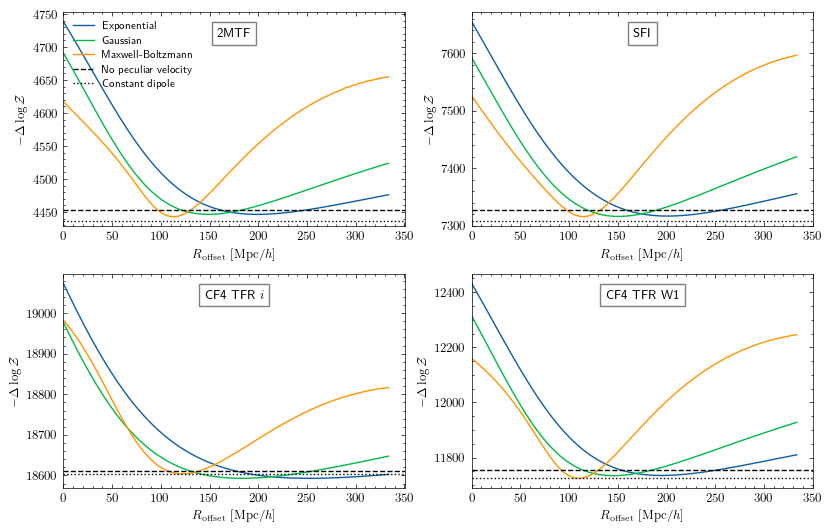

In [50]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})

    figwidth = 8.3 
    fig, axs = plt.subplots(2, 2, figsize=(figwidth, 0.65 * figwidth))

    for n, cat in enumerate(cats):
        i, j = n // 2, n % 2
        ax = axs[i, j]

        for sim in sims:
            x = kfound[f"{sim}_{cat}"]
            y = [neglnZ[f"{sim}_{cat}_{ksim}"] / np.log(10) for ksim in x]
            x = np.array(x) * 0.674
            ax.plot(x, y, label=simname_to_pretty(sim))
        
        # if no_Vext is None:
        #     y_no_field = neglnZ_no_field[cat] / np.log(10)
        #     if cat != "CF4_TFR_w1":
        #         ax.axhline(y_no_field, color="black", ls="--", label="No peculiar velocity")
        y_no_field = neglnZ_no_field[cat] / np.log(10)
        ax.axhline(y_no_field, color="black", ls="--", label="No peculiar velocity")

        y_dipole = neglnZ_dipole[cat] / np.log(10)
        ax.axhline(y_dipole, color="black", ls=":", label="Constant dipole")

        ax.text(0.5, 0.9, catalogue_to_pretty(cat),
            transform=ax.transAxes, #fontsize="small",
            verticalalignment='center', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.5),
            )

        if n == 0:
            ax.legend(fontsize="small", loc="upper left")

        ax.set_ylabel(r"$-\Delta \log \mathcal{Z}$")
        ax.set_xlabel(r"$R_{\rm offset} ~ [\mathrm{Mpc} / h]$")
        ax.set_xlim(0)

    fig.tight_layout()
    fname = f"../../plots/void_goodness_of_fit_observer.png"
    if no_Vext:
        fname = fname.replace(".png", "_no_Vext.png")
    print(f"Saving to `{fname}`.")
    fig.savefig(fname, dpi=450)
    fig.show()


### Single parameter radial dependence

In [20]:
zcmb_max = 0.05
key = "Vext"
# key_label = r"$\sigma_v ~ [\mathrm{km} / \mathrm{s}]$"
key_label = r"$|\mathbf{V}_{\rm ext}| ~ [\mathrm{km} / \mathrm{s}]$"
no_Vext = None

sims = ["IndranilVoid_exp", "IndranilVoid_gauss", "IndranilVoid_mb"]
cats = ["2MTF", "SFI_gals", "CF4_TFR_i", "CF4_TFR_w1"]

data_mean = {}
data_std = {}
kfound = {}
for sim in sims:
    for cat in cats:
        kfound[f"{sim}_{cat}"] = []
        for ksim in range(500):
            sample_alpha = False
            fname = paths.flow_validation(
                fdir, sim, cat, inference_method="mike", nsim=ksim,
                sample_alpha=sample_alpha, zcmb_max=zcmb_max,
                no_Vext=no_Vext, verbose_print=False)

            if not exists(fname):
                continue

            kfound[f"{sim}_{cat}"].append(ksim)
            with File(fname, 'r') as f:
                x = f[f"samples/{key}"][...]
            if key == "Vext":
                x = np.linalg.norm(x, axis=-1)

            data_mean[f"{sim}_{cat}_{ksim}"] = x.mean()
            data_std[f"{sim}_{cat}_{ksim}"] = x.std()

Saving to `../../plots/void_Vext_per_observer.png`.


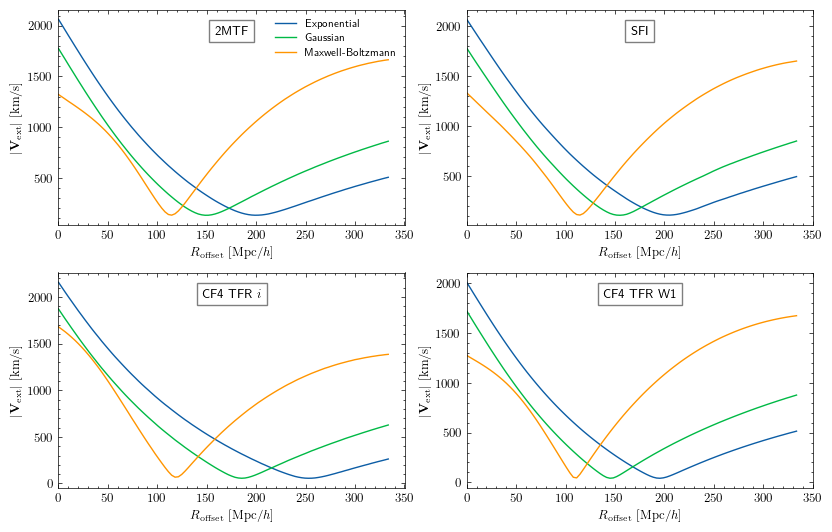

In [22]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})

    figwidth = 8.3
    fig, axs = plt.subplots(2, 2, figsize=(figwidth, 0.65 * figwidth))

    for n, cat in enumerate(cats):
        i, j = n // 2, n % 2
        ax = axs[i, j]

        for sim in sims:
            x = kfound[f"{sim}_{cat}"]
            y = [data_mean[f"{sim}_{cat}_{ksim}"] for ksim in x]
            yerr = [data_std[f"{sim}_{cat}_{ksim}"] for ksim in x]
            x = np.array(x) * 0.674

            ax.plot(x, y, label=simname_to_pretty(sim))
            # ax.fill_between(x, np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), alpha=0.5)

        ax.text(0.5, 0.9, catalogue_to_pretty(cat),
            transform=ax.transAxes, #fontsize="small",
            verticalalignment='center', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.5),
            )

        if n == 0:
            ax.legend(fontsize="small", loc='upper right')

        ax.set_ylabel(key_label)
        ax.set_xlabel(r"$R_{\rm offset} ~ [\mathrm{Mpc} / h]$")
        ax.set_xlim(0),

    fig.tight_layout()
    fname = f"../../plots/void_{key}_per_observer.png"
    if no_Vext:
        fname = fname.replace(".png", "_no_Vext.png")
    print(f"Saving to `{fname}`.")
    fig.savefig(fname, dpi=450)
    fig.show()